<a href="https://colab.research.google.com/github/jmakings/Breast-Cancer-Classifiers-Project/blob/main/CSE_283_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.metrics import precision_score, balanced_accuracy_score, recall_score, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
random.seed(10)

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# metadata of patients with breast cancer. Last column is R/N for recurrence vs non-recurrence
cancermeta = pd.read_csv("/content/pnas_patient_info.csv")
validcancer = pd.read_excel('/content/validation_bc_meta.xlsx')
validnormal = pd.read_excel('/content/validation_normal_meta.xlsx')

In [ ]:
# readcounts/transcripts per million for breast cancer patients, non-cancer patients, and validation dataset
readcounts = pd.read_csv("/content/pnas_readcounts_96_nodup.txt",sep="\t")
readtpm = pd.read_csv("/content/pnas_tpm_96_nodup.txt",sep="\t")
normalcounts = pd.read_csv("/content/pnas_normal_readcounts.txt",sep="\t")
normaltpm = pd.read_csv("/content/pnas_normal_tpm.txt",sep="\t")
validcounts = pd.read_csv("/content/validation_exon_readcounts",sep="\t")
validtpm = pd.read_csv("/content/validation_exon_tpm",sep="\t")

In [ ]:
# numpy array of recurrence status of 96 cancer patients, for dependent variable of classifier
recurstatus = cancermeta['recurStatus'].to_numpy()

In [ ]:
recurstatus = [1 if i == 'R' else 0 for i in recurstatus ]

In [ ]:
#columns annotated this way so the first patient in each pandas dataframe is index #1 
columns = ["C"+str(i) for i in range(0,97)]
ncolumns = ["N"+str(i) for i in range(1,33)]
vlen = len(validcounts.T)

In [ ]:
readtpm.columns = columns 
readcounts.columns = columns
normalcounts.columns = ncolumns 
normaltpm.columns = ncolumns

In [ ]:
# makes the gene names the index
readtpm = readtpm.set_index("C0")
readcounts = readcounts.set_index("C0")
readtpmT = readtpm.T 

In [ ]:
# default support vector machine w/ cross validation for all tpm counts
svmlinear = svm.SVC(kernel="linear", C=1, random_state=42)
svmbaseline = cross_val_score(svmlinear, readtpmT, recurstatus, cv=3)
svmpreds = cross_val_predict(svmlinear, readtpmT, recurstatus, cv=3)
svmbaseline

array([0.6875 , 0.65625, 0.59375])

In [ ]:
# random forest 
rf = RandomForestClassifier()
rfbaseline = cross_val_score(rf, readtpmT, recurstatus, cv=3)
rfpreds = cross_val_predict(rf, readtpmT, recurstatus, cv=3)
rfbaseline

array([0.6875 , 0.71875, 0.71875])

In [ ]:
# this predicts the same class every time, so obviously there's some work to be done
rfpreds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#select k best features, given an array of k values, and the x and y of a training set
def kBestArray(array, x, y): 
  featureSet = []
  featureNames = []
  scoresVals = []
  for i in array: 
    cls = SelectKBest(f_classif, k=i)
    f = cls.fit_transform(x,y)
    scores = cls.fit(x,y).scores_
    names = cls.get_feature_names_out()
    featureSet.append(f)
    featureNames.append(names)
    scoresVals.append(scores)
  return featureSet, featureNames, scoresVals

In [ ]:
numFeatures = [5,10,25,50,100,200, 500, 1000, 5000, 10000, 20000, 30000, 60000]
featureArray, namesRecur, fscores = kBestArray(numFeatures,readtpmT, recurstatus)

In [ ]:
#given an array of the top features, training set y, a classifier to train, and a k for k-fold cross validation,
#returns k-fold accuracy scores, predictions, and fpr and tpr for graphing Area under Reciever Operating Characteristic
def kFoldArrTest(array, y, cls, k):
  scores = {}
  preds = {}
  roc_arrays = {}
  #rocs = {}
  for i in array: 
    s = cross_val_score(cls, i, y,cv=k)
    s = [round(i,5) for i in s]
    p = cross_val_predict(cls, i, y,cv=k)
    probs = cross_val_predict(cls, i , y,cv=k,method='predict_proba')[:,1]
    fpr, tpr, thresholds = roc_curve(y, probs)
    roc_inner = [fpr, tpr]
    roc = roc_auc_score(y, probs)

    numfeats = i.shape[1]
    scores[numfeats] = {"Acc":s, "ROC":roc}
    #rocs[numfeats] = roc 
    preds[numfeats] = p
    roc_arrays[numfeats] = roc_inner
  return scores, preds, roc_arrays

In [ ]:
scores, preds, rocs = kFoldArrTest(featureArray, recurstatus, rf,3) 

In [ ]:
#graphs Area under Reciever Operating Characteristic, given a dictionary entry from "kFoldArrTest"
def graphROC(ROClist, title,score): #dict index from testFeatures, title, and dict index from scores
  print(len(ROClist))
  if len(ROClist) == 2: 
    fpr = ROClist[0]
    tpr = ROClist[1]
    plt.plot(fpr,tpr)
  else:
    for i in ROClist:
      fpr = i[0]
      tpr = i[1]
      plt.plot(fpr,tpr)
  mean = round(score['ROC'], 4)
  plt.text(0.3,0.1,f"Average AUC: {mean}", fontdict = {'size':14})
  plt.xlabel('False Positive Rate')
  plt.ylabel("True Positive Rate")
  plt.plot([0,1],[0,1], linestyle= 'dashed')
  plt.title(title)


2


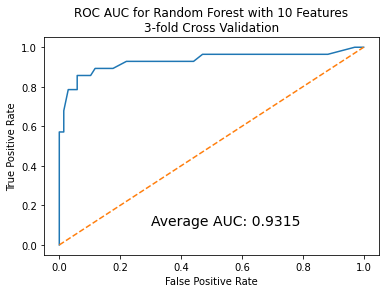

In [ ]:
graphROC(rocs[10], "ROC AUC for Random Forest with 10 Features\n3-fold Cross Validation", scores[10])

In [ ]:
#looking like using the 10 features with highest variance nets pretty good predictions
scores

{5: {'Acc': [0.71875, 0.90625, 0.75], 'ROC': 0.8728991596638654},
 10: {'Acc': [0.875, 0.90625, 0.875], 'ROC': 0.9314600840336136},
 25: {'Acc': [0.75, 0.875, 0.8125], 'ROC': 0.9338235294117647},
 50: {'Acc': [0.78125, 0.84375, 0.78125], 'ROC': 0.9522058823529412},
 100: {'Acc': [0.90625, 0.75, 0.8125], 'ROC': 0.9813550420168068},
 200: {'Acc': [0.6875, 0.78125, 0.75], 'ROC': 0.9900210084033614},
 500: {'Acc': [0.78125, 0.75, 0.8125], 'ROC': 0.9703256302521008},
 1000: {'Acc': [0.71875, 0.78125, 0.71875], 'ROC': 0.9816176470588235},
 5000: {'Acc': [0.6875, 0.71875, 0.71875], 'ROC': 0.9611344537815126},
 10000: {'Acc': [0.6875, 0.75, 0.71875], 'ROC': 0.8973214285714286},
 20000: {'Acc': [0.6875, 0.71875, 0.71875], 'ROC': 0.8537289915966386},
 30000: {'Acc': [0.6875, 0.71875, 0.71875], 'ROC': 0.8293067226890756},
 60000: {'Acc': [0.6875, 0.71875, 0.71875], 'ROC': 0.5186449579831933}}

In [ ]:
def plotfromScoresLog(testscore, title): 
  nums = list(testscore.keys())
  scores = []
  for i in testscore.values(): 
    scores.append(i['ROC'])
  plt.title(title)
  plt.xscale('log')
  plt.xlabel("Genes used as Features (log scale)")
  plt.ylabel("ROC AUC Score")
  plt.plot(nums,scores)

In [ ]:
def plotfromScores(testscore, title): 
  nums = list(testscore.keys())
  scores = []
  for i in testscore.values(): 
    scores.append(i['ROC'])
  plt.title(title)
  plt.xlabel("Genes used as Features")
  plt.ylabel("ROC AUC Score")
  plt.plot(nums,scores)

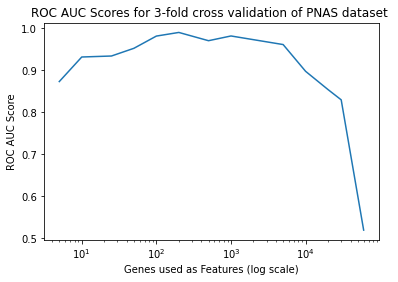

In [ ]:
plotfromScoresLog(scores, "ROC AUC Scores for 3-fold cross validation of PNAS dataset ")

In [ ]:
scores

{5: {'Acc': [0.71875, 0.90625, 0.75], 'ROC': 0.8728991596638654},
 10: {'Acc': [0.875, 0.90625, 0.875], 'ROC': 0.9314600840336136},
 25: {'Acc': [0.75, 0.875, 0.8125], 'ROC': 0.9338235294117647},
 50: {'Acc': [0.78125, 0.84375, 0.78125], 'ROC': 0.9522058823529412},
 100: {'Acc': [0.90625, 0.75, 0.8125], 'ROC': 0.9813550420168068},
 200: {'Acc': [0.6875, 0.78125, 0.75], 'ROC': 0.9900210084033614},
 500: {'Acc': [0.78125, 0.75, 0.8125], 'ROC': 0.9703256302521008},
 1000: {'Acc': [0.71875, 0.78125, 0.71875], 'ROC': 0.9816176470588235},
 5000: {'Acc': [0.6875, 0.71875, 0.71875], 'ROC': 0.9611344537815126},
 10000: {'Acc': [0.6875, 0.75, 0.71875], 'ROC': 0.8973214285714286},
 20000: {'Acc': [0.6875, 0.71875, 0.71875], 'ROC': 0.8537289915966386},
 30000: {'Acc': [0.6875, 0.71875, 0.71875], 'ROC': 0.8293067226890756},
 60000: {'Acc': [0.6875, 0.71875, 0.71875], 'ROC': 0.5186449579831933}}

In [ ]:
ScoreDF = pd.DataFrame(data=scores).T
ScoreDF.columns = ['3-Fold Accuracy Scores', 'ROC AUC Score']
ScoreDF.index.name = 'Genes Used'

In [ ]:
acc = ScoreDF['3-Fold Accuracy Scores']
ScoreDF.drop(columns=['3-Fold Accuracy Scores'], inplace=True)
newAcc = [np.mean(i) for i in acc]
ScoreDF['Mean 3-Fold Accuracy'] = newAcc 


In [ ]:
ScoreDF

,ROC AUC Score,Mean 3-Fold Accuracy
Genes Used,,
5,0.872899,0.791667
10,0.93146,0.885417
25,0.933824,0.812500
50,0.952206,0.802083
100,0.981355,0.822917
200,0.990021,0.739583
500,0.970326,0.781250
1000,0.981618,0.739583
5000,0.961134,0.708333


In [ ]:
def AccAucGraph(scores, title):
  x = []
  y = []
  z = []
  for i in scores.keys(): 
    mean = np.mean(scores[i]['Acc'])
    auc = scores[i]['ROC']
    x.append(i) 
    y.append(mean)
    z.append(auc)
  plt.plot(x,y)
  plt.plot(x,z)
  plt.xscale('log')
  plt.xlabel('Number of Features (Log)')
  plt.legend(["Mean Classifier Accuracy", "Mean ROC AUC Score"])
  plt.title(title)

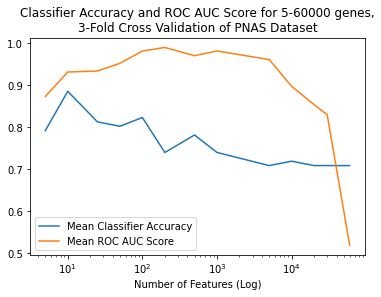

In [ ]:
AccAucGraph(scores, 'Classifier Accuracy and ROC AUC Score for 5-60000 genes,\n3-Fold Cross Validation of PNAS Dataset')

In [ ]:
def meanScore(scores):
  vals = {}
  for key, values in scores.items(): 
    print(f"{key}: Mean: {np.mean(values)} Std: {np.std(values)}")
    vals[key] = [np.mean(values), np.std(values)]
  return vals

In [ ]:
preds[10]

array([0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Next: refine to looking at between 6-25 features, get the gene names 
# of these most predictive features, and test on validation set

In [ ]:
#refining # of features: 
refinedSearch, refinedFeats, refinedVal = kBestArray([6,8,9,10,11,12,15,20,23],readtpmT, recurstatus)

In [ ]:
refineScore, refinePred, rocRefine = kFoldArrTest(refinedSearch, recurstatus, rf, 3)

In [ ]:
# ten still seems to be the best
meanScore(refineScore[10])

Acc: Mean: 0.9270833333333334 Std: 0.01473139127471974
ROC: Mean: 0.9356617647058824 Std: 0.0


{'Acc': [0.9270833333333334, 0.01473139127471974],
 'ROC': [0.9356617647058824, 0.0]}

In [ ]:
#try with dataframe to get features 
selector = SelectKBest(f_classif, k=10)
selector.fit(readtpmT,recurstatus)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  277   362  1970 ... 60659 60665 60668] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest()

In [ ]:
namesRecur[:2]

[array(['ENSG00000164111', 'ENSG00000172201', 'ENSG00000259657',
        'ENSG00000277692', 'ENSG00000279198'], dtype=object),
 array(['ENSG00000005020', 'ENSG00000116337', 'ENSG00000164111',
        'ENSG00000172201', 'ENSG00000178695', 'ENSG00000233337',
        'ENSG00000259657', 'ENSG00000269931', 'ENSG00000277692',
        'ENSG00000279198'], dtype=object)]

In [ ]:
featureArray2, namesRecur2, fscores2 = kBestArray([1,2,3,4,5,6,7,8, 9,10],readtpmT, recurstatus)

In [ ]:
namesRecur[:2]

[array(['ENSG00000164111', 'ENSG00000172201', 'ENSG00000259657',
        'ENSG00000277692', 'ENSG00000279198'], dtype=object),
 array(['ENSG00000005020', 'ENSG00000116337', 'ENSG00000164111',
        'ENSG00000172201', 'ENSG00000178695', 'ENSG00000233337',
        'ENSG00000259657', 'ENSG00000269931', 'ENSG00000277692',
        'ENSG00000279198'], dtype=object)]

In [ ]:
namesRecur2

[array(['ENSG00000279198'], dtype=object),
 array(['ENSG00000172201', 'ENSG00000279198'], dtype=object),
 array(['ENSG00000164111', 'ENSG00000172201', 'ENSG00000279198'],
       dtype=object),
 array(['ENSG00000164111', 'ENSG00000172201', 'ENSG00000259657',
        'ENSG00000279198'], dtype=object),
 array(['ENSG00000164111', 'ENSG00000172201', 'ENSG00000259657',
        'ENSG00000277692', 'ENSG00000279198'], dtype=object),
 array(['ENSG00000164111', 'ENSG00000172201', 'ENSG00000178695',
        'ENSG00000259657', 'ENSG00000277692', 'ENSG00000279198'],
       dtype=object),
 array(['ENSG00000116337', 'ENSG00000164111', 'ENSG00000172201',
        'ENSG00000178695', 'ENSG00000259657', 'ENSG00000277692',
        'ENSG00000279198'], dtype=object),
 array(['ENSG00000005020', 'ENSG00000116337', 'ENSG00000164111',
        'ENSG00000172201', 'ENSG00000178695', 'ENSG00000259657',
        'ENSG00000277692', 'ENSG00000279198'], dtype=object),
 array(['ENSG00000005020', 'ENSG00000116337', 'ENSG000

In [ ]:
def getTPMarrays(geneName): 
  recur = readtpmT[:28][geneName]
  nonrecur = readtpmT[28:][geneName]
  return nonrecur, recur

In [ ]:
# to make violin plot for TPM counts of a certain between recurrent and nonrecurrent cancer samples for a 
def violin(nonrecur, recur, name): 
  top = pd.DataFrame({'Nonrecurrent': nonrecur, 'Recurrent':recur })
  sns.violinplot(data=top)
  plt.xlabel("Breast Cancer Type")
  plt.ylabel("TPM")
  plt.title(f"TPM values for {name}\n(PNAS dataset)")

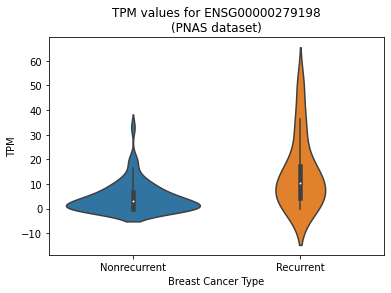

In [ ]:
r, n = getTPMarrays('ENSG00000279198')
violin(r,n,'ENSG00000279198')

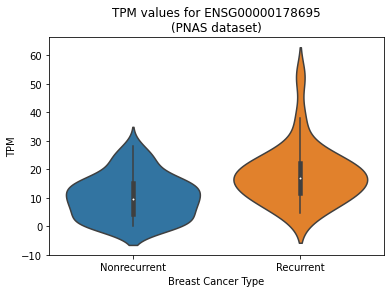

In [ ]:
kctd12r, kctd12n = getTPMarrays('ENSG00000178695')
violin(kctd12r, kctd12n,'ENSG00000178695')

In [ ]:
def getMeans(array): 
  countsRecur = 0
  for i in array:
    if (i != 0): 
      countsRecur += 1 
  return sum(array)/countsRecur

In [ ]:
id4n, id4r = getTPMarrays('ENSG00000172201')

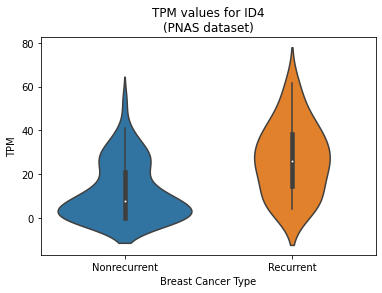

In [ ]:
violin(id4n,id4r, "ID4")

In [ ]:
anxn, anxr = getTPMarrays('ENSG00000164111')

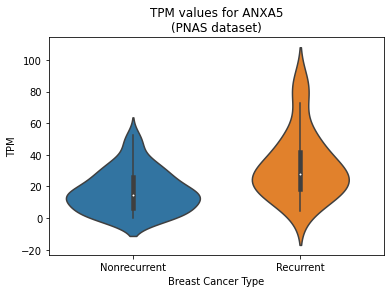

In [ ]:
violin(anxn,anxr, 'ANXA5')

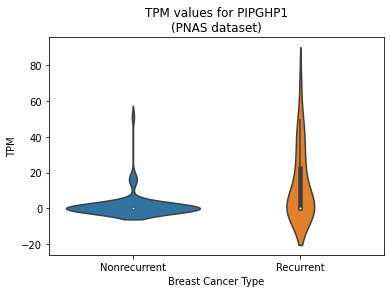

In [ ]:
pipn, pipr = getTPMarrays('ENSG00000259657')
violin(pipn,pipr, 'PIPGHP1')

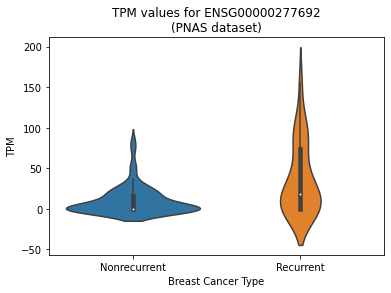

In [ ]:
pipn, pipr = getTPMarrays('ENSG00000277692')
violin(pipn,pipr, 'ENSG00000277692')

In [ ]:
recurVals = readtpmT[:28]['ENSG00000279198']
countsRecur = 0
for i in recurVals: 
  if (i != 0): 
    countsRecur += 1 
sum(recurVals)/countsRecur

16.917798626817692

In [ ]:
vals = readtpmT[28:]['ENSG00000279198']
counts = 0
for i in vals: 
  if (i != 0): 
    counts += 1 
sum(vals)/counts

7.830799545967079

In [ ]:
top = pd.DataFrame({'Nonrecurrent': vals, 'Recurrent':recurVals })

Text(0.5, 1.0, 'TPM values for ENSG00000279198\n(PNAS dataset)')

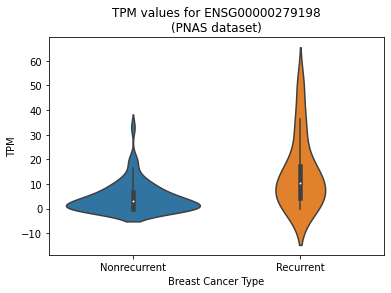

In [ ]:
sns.violinplot(data=top)
plt.xlabel("Breast Cancer Type")
plt.ylabel("TPM")
plt.title("TPM values for ENSG00000279198\n(PNAS dataset)")

In [ ]:
16.917798626817692/7.830799545967079

2.1604177871633152

In [ ]:
# research these genes to find their role in cancer recurrence
names = selector.get_feature_names_out()
names

array(['ENSG00000005020', 'ENSG00000116337', 'ENSG00000164111',
       'ENSG00000172201', 'ENSG00000178695', 'ENSG00000233337',
       'ENSG00000259657', 'ENSG00000269931', 'ENSG00000277692',
       'ENSG00000279198'], dtype=object)

In [ ]:
# cross validation of the best classifier so far 
bestFeats = selector.fit_transform(readtpmT,recurstatus)
bestScore = cross_val_score(rf, bestFeats, recurstatus,cv=3)
bestPreds = cross_val_predict(rf, bestFeats, recurstatus,cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  277   362  1970 ... 60659 60665 60668] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
bestScore

array([0.90625, 0.90625, 0.84375])

In [ ]:
bestPreds

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# recreate this classifier with the whole dataset
bestClf = RandomForestClassifier().fit(bestFeats, recurstatus)
trainingScore = bestClf.score(bestFeats, recurstatus)
trainingScore

1.0

In [ ]:
# preprocessing the validation dataset for use with the classifier
valrecurstatus = validcancer["Recurrence Staus at the time of collection"].to_numpy()
mapIDs = validcancer['Mapping ID'].to_numpy()

In [ ]:
valrecurY = [0 if i == "Nonrecurrent" else 1 for i in valrecurstatus]

In [ ]:
canvaltpm = validtpm.copy(deep=True)

In [ ]:
for i in canvaltpm.columns: 
  if i in mapIDs: 
    continue
  else: 
    canvaltpm.drop(labels = [i], axis=1, inplace=True)

In [ ]:
canvaltpmT = canvaltpm.T

In [ ]:
canvalBestFeats = canvaltpmT[names]

In [ ]:
canvalBestFeats

,ENSG00000005020,ENSG00000116337,ENSG00000164111,ENSG00000172201,ENSG00000178695,ENSG00000233337,ENSG00000259657,ENSG00000269931,ENSG00000277692,ENSG00000279198
BCSC_S5_40,20.466541,14.010625,8.593021,14.830048,11.168396,0.000000,15.381254,0.000000,0.000000,0.000000
BCSC_S5_41,22.611085,11.759791,14.692202,11.410275,22.914642,17.013794,0.000000,19.658717,0.000000,2.873100
BCSC_S5_42,19.354955,11.744030,22.008766,28.487455,8.581474,0.000000,0.000000,0.000000,19.581993,0.000000
BCSC_S5_43,8.748092,1.769363,27.853185,30.901961,11.636016,46.077734,64.101060,39.930649,53.104250,0.000000
BCSC_S5_44,21.138382,6.840620,7.691751,14.933942,14.995517,0.000000,0.000000,0.000000,85.545358,30.082853
...,...,...,...,...,...,...,...,...,...,...
BCSC_S6_70,17.909702,5.268893,23.697862,15.336884,14.437613,17.151554,15.906928,0.000000,26.356053,11.585452
BCSC_S6_71,15.689277,4.231023,28.544763,12.315815,13.912419,0.000000,0.000000,31.828302,0.000000,6.202228
BCSC_S6_72,24.914659,2.519583,28.330776,18.335234,15.188937,0.000000,0.000000,9.476910,12.603457,22.160638
BCSC_S6_73,21.654556,8.759574,23.638724,25.497685,19.202112,0.000000,21.156310,52.715832,0.000000,19.260901


In [ ]:
# results of this classifier: very poor, balanced accuracy rate of 52% 
valScore = bestClf.score(canvalBestFeats,valrecurY)
valPreds = bestClf.predict(canvalBestFeats)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
precision_score(valrecurY, valPreds)

0.07692307692307693

In [ ]:
balanced_accuracy_score(valrecurY, valPreds)

0.4825

In [ ]:
names

array(['ENSG00000005020', 'ENSG00000116337', 'ENSG00000164111',
       'ENSG00000172201', 'ENSG00000178695', 'ENSG00000233337',
       'ENSG00000259657', 'ENSG00000269931', 'ENSG00000277692',
       'ENSG00000279198'], dtype=object)

In [ ]:
rfbal = RandomForestClassifier(class_weight='balanced')
rfnorm = RandomForestClassifier()

In [ ]:
def testFeatures(featMatrix,featNames, y_train, cls, x_test, y_test, reps):
  preds = {}
  scores = {}
  roc_arrays = {}
  for i, j in zip(featMatrix, featNames):
    acc = 0
    ba = 0
    roc = 0
    roc_inner = []
    for x in range(0,reps):
      size = len(i[0])
      x_test2 = x_test[j]
      fitcls = cls.fit(i,y_train)
      p = fitcls.predict(x_test2)
      y_score = fitcls.predict_proba(x_test2)[:,1]
      fpr, tpr, thresholds = roc_curve(y_test, y_score)
      roc_inner.append([fpr, tpr])
      acc += fitcls.score(x_test2, y_test)
      ba += balanced_accuracy_score(y_test, p)
      roc += roc_auc_score(y_test, y_score)
      preds[size] = p
    
    scores[size] = {"Accuracy": acc/reps, "Balanced Accuracy": ba/reps, "ROC": roc/reps}
    roc_arrays[size] = roc_inner

  return preds, scores, roc_arrays

In [ ]:
bestpreds, bestscores, bestROC = testFeatures(featureArray,namesRecur, recurstatus, rfbal, canvaltpmT, valrecurY, 5)

In [ ]:
bestscores

{5: {'Accuracy': 0.7397590361445783,
  'Balanced Accuracy': 0.6214999999999999,
  'ROC': 0.5451666666666667},
 10: {'Accuracy': 0.7855421686746988,
  'Balanced Accuracy': 0.5463333333333333,
  'ROC': 0.6785},
 25: {'Accuracy': 0.8433734939759037,
  'Balanced Accuracy': 0.5001666666666666,
  'ROC': 0.6035000000000001},
 50: {'Accuracy': 0.8722891566265061,
  'Balanced Accuracy': 0.48266666666666663,
  'ROC': 0.6001666666666666},
 100: {'Accuracy': 0.9012048192771085,
  'Balanced Accuracy': 0.49866666666666665,
  'ROC': 0.541},
 200: {'Accuracy': 0.9036144578313253,
  'Balanced Accuracy': 0.5,
  'ROC': 0.5181666666666667},
 500: {'Accuracy': 0.9012048192771085,
  'Balanced Accuracy': 0.49866666666666665,
  'ROC': 0.5283333333333333},
 1000: {'Accuracy': 0.9036144578313253,
  'Balanced Accuracy': 0.5,
  'ROC': 0.4713333333333334},
 5000: {'Accuracy': 0.9036144578313253,
  'Balanced Accuracy': 0.5,
  'ROC': 0.5465},
 10000: {'Accuracy': 0.9036144578313253,
  'Balanced Accuracy': 0.5,
  'RO

In [ ]:
bestpreds[10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [ ]:
np.array(valrecurY)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
def graphROCdict(ROCdict):
  for key in ROCdict.keys():
    graphROC(ROCdict[key])

In [ ]:
bestpreds[50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

5


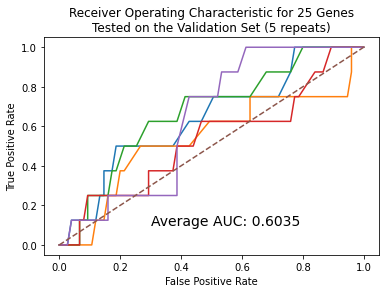

In [ ]:
graphROC(bestROC[25], "Receiver Operating Characteristic for 25 Genes\nTested on the Validation Set (5 repeats)", bestscores[25])

5


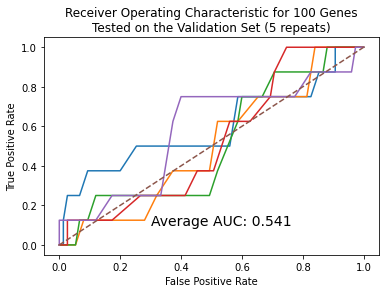

In [ ]:
graphROC(bestROC[100], "Receiver Operating Characteristic for 100 Genes\nTested on the Validation Set (5 repeats)", bestscores[100])

In [ ]:
bestscores

{5: {'Accuracy': 0.7397590361445783,
  'Balanced Accuracy': 0.6214999999999999,
  'ROC': 0.5451666666666667},
 10: {'Accuracy': 0.7855421686746988,
  'Balanced Accuracy': 0.5463333333333333,
  'ROC': 0.6785},
 25: {'Accuracy': 0.8433734939759037,
  'Balanced Accuracy': 0.5001666666666666,
  'ROC': 0.6035000000000001},
 50: {'Accuracy': 0.8722891566265061,
  'Balanced Accuracy': 0.48266666666666663,
  'ROC': 0.6001666666666666},
 100: {'Accuracy': 0.9012048192771085,
  'Balanced Accuracy': 0.49866666666666665,
  'ROC': 0.541},
 200: {'Accuracy': 0.9036144578313253,
  'Balanced Accuracy': 0.5,
  'ROC': 0.5181666666666667},
 500: {'Accuracy': 0.9012048192771085,
  'Balanced Accuracy': 0.49866666666666665,
  'ROC': 0.5283333333333333},
 1000: {'Accuracy': 0.9036144578313253,
  'Balanced Accuracy': 0.5,
  'ROC': 0.4713333333333334},
 5000: {'Accuracy': 0.9036144578313253,
  'Balanced Accuracy': 0.5,
  'ROC': 0.5465},
 10000: {'Accuracy': 0.9036144578313253,
  'Balanced Accuracy': 0.5,
  'RO

In [ ]:
predsRecurNorm, scoreRecurNorm, rocRecurNorm = testFeatures(featureArray,namesRecur, recurstatus, rfnorm, canvaltpmT, valrecurY, 5)

In [ ]:
scoreRecurNorm 

{5: {'Accuracy': 0.7156626506024096,
  'Balanced Accuracy': 0.5746666666666667,
  'ROC': 0.5616666666666668},
 10: {'Accuracy': 0.7566265060240964,
  'Balanced Accuracy': 0.5414999999999999,
  'ROC': 0.6586666666666667},
 25: {'Accuracy': 0.8168674698795181,
  'Balanced Accuracy': 0.5078333333333334,
  'ROC': 0.5668333333333333},
 50: {'Accuracy': 0.8506024096385542,
  'Balanced Accuracy': 0.493,
  'ROC': 0.5606666666666666},
 100: {'Accuracy': 0.8963855421686748,
  'Balanced Accuracy': 0.5071666666666667,
  'ROC': 0.5028333333333334},
 200: {'Accuracy': 0.9012048192771085,
  'Balanced Accuracy': 0.49866666666666665,
  'ROC': 0.5765},
 500: {'Accuracy': 0.9012048192771085,
  'Balanced Accuracy': 0.49866666666666665,
  'ROC': 0.5063333333333333},
 1000: {'Accuracy': 0.9036144578313253,
  'Balanced Accuracy': 0.5,
  'ROC': 0.4671666666666667},
 5000: {'Accuracy': 0.9036144578313253,
  'Balanced Accuracy': 0.5,
  'ROC': 0.5886666666666667},
 10000: {'Accuracy': 0.9036144578313253,
  'Bala

In [ ]:
def plotBARlog(testscore, title): 
  nums = list(testscore.keys())
  scores = []
  bar = []
  for i in testscore.values():
    bar.append(i['Balanced Accuracy'])
    scores.append(i['ROC'])
  plt.title(title)
  plt.xscale('log')
  plt.xlabel("Genes used as Features (log)")
  plt.plot(nums,scores)
  plt.plot(nums, bar)
  plt.legend([ "Mean ROC AUC Score", "Mean Balanced Accuracy"])

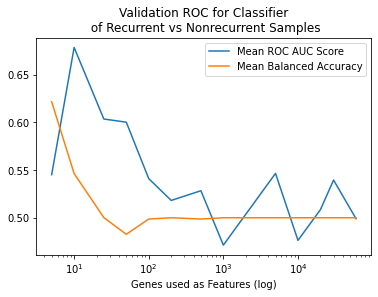

In [ ]:
plotBARlog(bestscores, "Validation ROC for Classifier\n of Recurrent vs Nonrecurrent Samples")

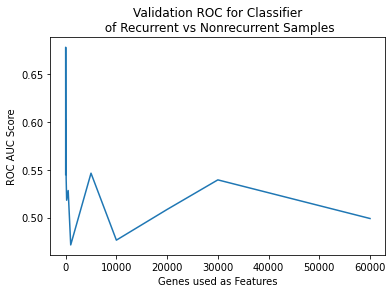

In [ ]:
plotfromScores(bestscores, "Validation ROC for Classifier\n of Recurrent vs Nonrecurrent Samples")

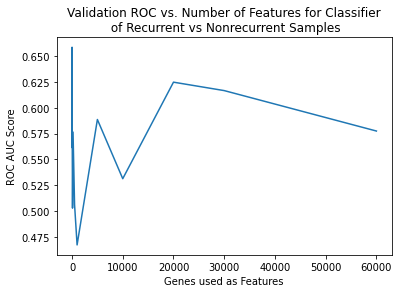

In [ ]:
plotfromScores(scoreRecurNorm, "Validation ROC vs. Number of Features for Classifier\n of Recurrent vs Nonrecurrent Samples")

**New strategy: Take from this research paper:**
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5559645/
Review article: https://www.breastcancer.org/research-news/recurrences-may-have-different-genetics

Goal is to take top genes associated with recurrent breast cancer from this paper

In [ ]:
paperGenes = {"STAT3":"ENSG00000168610", "ES41": "ENSG00000041353", "FANCD2": "ENSG00000144554", 
              "FOX1":"ENSG00000144554", "ARID1A":"ENSG00000117713", "NF1":"ENSG00000196712", 
              "ARID1B":"ENSG00000049618", "BRCA1":"ENSG00000012048", "PIK3R1": "ENSG00000145675", 
              "AKT1": "ENSG00000142208", "TP53": "ENSG00000141510" }

In [ ]:
def trainRandomForest(feats, Y): 
  return RandomForestClassifier().fit(feats, Y)

In [ ]:
def getGenes(geneList, pandasDF): 
  features = pandasDF[geneList]
  return features

In [ ]:
geneList = [i for i in paperGenes.values()]

In [ ]:
# ensemble IDs for the genes found to be associated with recurrent breast cancer in this paper
geneList

['ENSG00000168610',
 'ENSG00000041353',
 'ENSG00000144554',
 'ENSG00000144554',
 'ENSG00000117713',
 'ENSG00000196712',
 'ENSG00000049618',
 'ENSG00000012048',
 'ENSG00000145675',
 'ENSG00000142208',
 'ENSG00000141510']

In [ ]:
paperFeats = getGenes(geneList, readtpmT)

In [ ]:
paperScores, paperPreds, paperROC = kFoldArrTest([paperFeats], recurstatus, rf,5)

In [ ]:
paperRF = trainRandomForest(paperFeats, recurstatus)

In [ ]:
def testRF(cls, x_test,y_test, reps):
  accuracy = 0
  ba = 0
  roc = 0
  for x in range(0,reps): 
    preds = cls.predict(x_test)
    accuracy += cls.score(x_test, y_test)
    ba += balanced_accuracy_score(y_test, preds)
    y_score = cls.predict_proba(x_test)[:,1]
    roc += roc_auc_score(y_test, y_score)
  
  scores = { "Accuracy": accuracy/reps, "Balanced Accuracy Rate": ba/reps , "ROC": roc/reps}
  return preds, scores

In [ ]:
valfeats = getGenes(geneList, canvaltpmT)

In [ ]:
# similarly poor results to using the most variance 
preds, scores = testRF(paperRF, valfeats, valrecurY, 5)
scores

{'Accuracy': 0.7469879518072289,
 'Balanced Accuracy Rate': 0.4691666666666666,
 'ROC': 0.5516666666666666}

In [ ]:
# combination method (10 genes with most variance + 10 genes from paper)
cancermeta

,poiseid,fu,Final.Library.Conc..nM.,Final.Library.Conc..ng.ul.,sample.name.in.MiniSeq,sample_id,On.Plate,readcount,avglength,uniquely_mapped_reads,...,cancertype,cancerstage_cat,er_cat,pr_cat,her2_cat,chemo,datechemostart,datechemoend,daterecurrence,recurStatus
0,2006,2,81.01,15.83,ZZ-20170524-Cellfree-10-01,S01_B14,A1,435826,75,370649,...,Ductal,3,0,0,0,AC/T,31/12/2008,08/04/2009,29/06/2009,R
1,2006,3,35.99,7.03,ZZ-20170524-Cellfree-10-02,S02_B14,A2,563731,75,481372,...,Ductal,3,0,0,0,AC/T,31/12/2008,08/04/2009,29/06/2009,R
2,2010,3,70.89,13.85,ZZ-20170524-Cellfree-10-03,S03_B14,A3,457102,74,399462,...,Ductal,2,0,0,0,AC/T,07/01/2009,20/05/2009,09/11/2010,R
3,2010,4,114.20,22.31,ZZ-20170524-Cellfree-10-04,S04_B14,A4,638280,75,562452,...,Ductal,2,0,0,0,AC/T,07/01/2009,20/05/2009,09/11/2010,R
4,2011,2,108.95,21.28,ZZ-20170524-Cellfree-10-05,S05_B14,A5,434579,75,382854,...,Ductal,3,1,1,0,AC/T,12/01/2009,27/04/2009,22/12/2010,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2005,3,14.16,2.77,ZZ-20170524-Cellfree-10-92,S92_B14,H8,351558,74,297278,...,Ductal,2,1,1,0,TC,12/11/2008,14/01/2009,01/03/2025,N
92,2003,2,114.52,22.37,ZZ-20170524-Cellfree-10-93,S93_B14,H9,446446,75,397125,...,Ductal,2,1,1,0,AC/T,24/10/2008,12/02/2009,01/03/2025,N
93,2003,3,67.67,13.22,ZZ-20170524-Cellfree-10-94,S94_B14,H10,367318,75,324069,...,Ductal,2,1,1,0,AC/T,24/10/2008,12/02/2009,01/03/2025,N
94,2002,2,38.65,7.55,ZZ-20170524-Cellfree-10-95,S95_B14,H11,363729,75,319003,...,Ductal,3,1,1,1,AC/T,13/10/2008,19/01/2009,01/03/2025,N


**Normal vs Cancer Classifier**

In [ ]:
# combine the normal and cancer samples
combinedtpm = pd.concat([readtpm, normaltpm], axis = 1, copy = True)
combinedtpm.drop(labels="ENSG00000000003", inplace = True)

In [ ]:
comblabel = [1 if i < 96 else 0 for i in range(0,128) ]

In [ ]:
normfeats, normnames, normVals = kBestArray([10,50,100,200,500, 700, 1000, 5000, 10000, 20000, 30000, 40000, 60674], combinedtpm.T, comblabel)

In [ ]:
validtpmT = validtpm.T

In [ ]:
normbalScore, normbalPred, normbalRoc = kFoldArrTest(normfeats, comblabel, rfbal, 3)

In [ ]:
normScore, normPred, normRoc = kFoldArrTest(normfeats, comblabel, rfnorm, 3)

In [ ]:
normbalScore

{10: {'Acc': [1.0, 0.97674, 1.0], 'ROC': 0.9996744791666667},
 50: {'Acc': [1.0, 1.0, 1.0], 'ROC': 1.0},
 100: {'Acc': [1.0, 1.0, 1.0], 'ROC': 1.0},
 200: {'Acc': [1.0, 1.0, 1.0], 'ROC': 1.0},
 500: {'Acc': [1.0, 1.0, 1.0], 'ROC': 1.0},
 700: {'Acc': [1.0, 1.0, 1.0], 'ROC': 1.0},
 1000: {'Acc': [1.0, 1.0, 1.0], 'ROC': 1.0},
 5000: {'Acc': [0.97674, 0.95349, 0.97619], 'ROC': 1.0},
 10000: {'Acc': [0.95349, 0.95349, 0.95238], 'ROC': 1.0},
 20000: {'Acc': [0.97674, 0.90698, 0.88095], 'ROC': 0.9998372395833334},
 30000: {'Acc': [0.88372, 0.88372, 0.78571], 'ROC': 1.0},
 40000: {'Acc': [0.90698, 0.93023, 0.78571], 'ROC': 0.99609375},
 60674: {'Acc': [0.86047, 0.88372, 0.80952], 'ROC': 0.9977213541666666}}

In [ ]:
normScoreDF = pd.DataFrame(data=normScore).T
normScoreDF.columns = ['3-Fold Accuracy Scores', 'ROC AUC Score']
normScoreDF.index.name = 'Number of Genes Used'

In [ ]:
normScoreDF

,3-Fold Accuracy Scores,ROC AUC Score
Number of Genes Used,,
10,"[1.0, 0.97674, 1.0]",1.0
50,"[1.0, 1.0, 1.0]",1.0
100,"[1.0, 1.0, 1.0]",1.0
200,"[1.0, 1.0, 1.0]",1.0
500,"[1.0, 1.0, 1.0]",1.0
700,"[1.0, 1.0, 1.0]",1.0
1000,"[1.0, 1.0, 1.0]",1.0
5000,"[1.0, 1.0, 1.0]",1.0
10000,"[0.97674, 1.0, 0.97619]",1.0


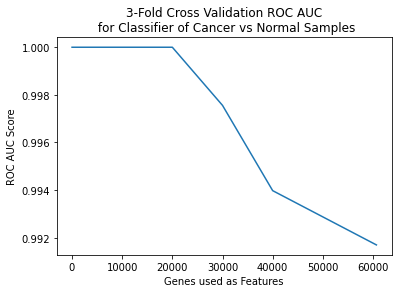

In [ ]:
plotfromScores(normScore, "3-Fold Cross Validation ROC AUC\n for Classifier of Cancer vs Normal Samples")

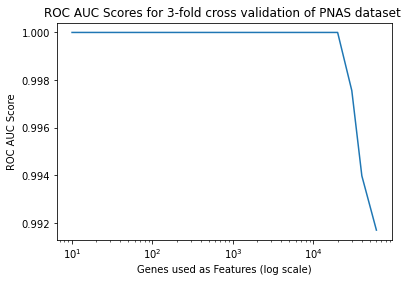

In [ ]:
plotfromScoresLog(normScore, "ROC AUC Scores for 3-fold cross validation of PNAS dataset ")

2


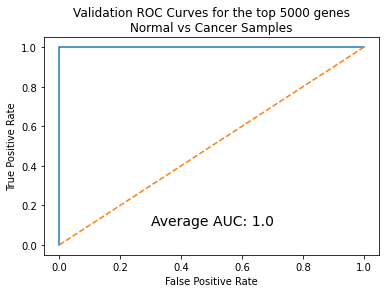

In [ ]:
graphROC(normRoc[5000], "Validation ROC Curves for the top 5000 genes\nNormal vs Cancer Samples" ,normScore[5000])

In [ ]:
# getting classification labels (Y values) from validation dataset
def validY(validnormal, validtpm): 
  y_vals = []
  for i in validtpm.columns:
    added = False
    for j in validnormal['Mapping ID']:
      if i == j: 
        y_vals.append(0)
        added = True
        break

    if added == False: 
      y_vals.append(1)
  return y_vals

In [ ]:
valY = validY(validnormal, validtpm)

In [ ]:
testpred, testscore, testroc = testFeatures(normfeats, normnames, comblabel, rfnorm, validtpmT, valY,10)

In [ ]:
testpred2, testscore2, roc2 = testFeatures(normfeats, normnames, comblabel, rfbal, validtpmT, valY, 10)

In [ ]:
testscore

{10: {'Accuracy': 0.51055900621118,
  'Balanced Accuracy': 0.4951807228915662,
  'ROC': 0.5888940376892183},
 50: {'Accuracy': 0.5167701863354036,
  'Balanced Accuracy': 0.5041396354649366,
  'ROC': 0.5393960457213469},
 100: {'Accuracy': 0.5167701863354036,
  'Balanced Accuracy': 0.503907939450108,
  'ROC': 0.5568427556379363},
 200: {'Accuracy': 0.520496894409938,
  'Balanced Accuracy': 0.5086422613531046,
  'ROC': 0.5621949335804757},
 500: {'Accuracy': 0.5260869565217391,
  'Balanced Accuracy': 0.5139481000926784,
  'ROC': 0.5984862527031202},
 700: {'Accuracy': 0.5285714285714286,
  'Balanced Accuracy': 0.5165894346617239,
  'ROC': 0.605800123571208},
 1000: {'Accuracy': 0.5341614906832298,
  'Balanced Accuracy': 0.5228606734630831,
  'ROC': 0.613453815261044},
 5000: {'Accuracy': 0.5652173913043478,
  'Balanced Accuracy': 0.5557228915662652,
  'ROC': 0.6503166512202657},
 10000: {'Accuracy': 0.5596273291925465,
  'Balanced Accuracy': 0.5499536607970343,
  'ROC': 0.664674080939141

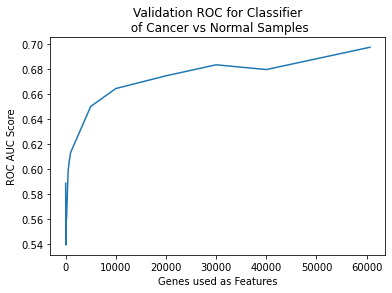

In [ ]:
plotfromScores(testscore, "Validation ROC for Classifier\n of Cancer vs Normal Samples")

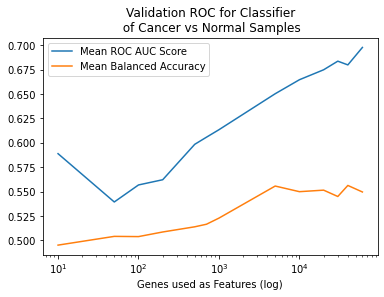

In [ ]:
plotBARlog(testscore, "Validation ROC for Classifier\n of Cancer vs Normal Samples")

10


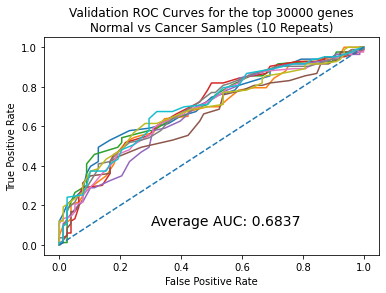

In [ ]:
graphROC(testroc[30000], "Validation ROC Curves for the top 30000 genes\nNormal vs Cancer Samples (10 Repeats)" ,testscore[30000])

In [ ]:
testscore

{10: {'Accuracy': 0.51055900621118,
  'Balanced Accuracy': 0.4951807228915662,
  'ROC': 0.5888940376892183},
 50: {'Accuracy': 0.5167701863354036,
  'Balanced Accuracy': 0.5041396354649366,
  'ROC': 0.5393960457213469},
 100: {'Accuracy': 0.5167701863354036,
  'Balanced Accuracy': 0.503907939450108,
  'ROC': 0.5568427556379363},
 200: {'Accuracy': 0.520496894409938,
  'Balanced Accuracy': 0.5086422613531046,
  'ROC': 0.5621949335804757},
 500: {'Accuracy': 0.5260869565217391,
  'Balanced Accuracy': 0.5139481000926784,
  'ROC': 0.5984862527031202},
 700: {'Accuracy': 0.5285714285714286,
  'Balanced Accuracy': 0.5165894346617239,
  'ROC': 0.605800123571208},
 1000: {'Accuracy': 0.5341614906832298,
  'Balanced Accuracy': 0.5228606734630831,
  'ROC': 0.613453815261044},
 5000: {'Accuracy': 0.5652173913043478,
  'Balanced Accuracy': 0.5557228915662652,
  'ROC': 0.6503166512202657},
 10000: {'Accuracy': 0.5596273291925465,
  'Balanced Accuracy': 0.5499536607970343,
  'ROC': 0.664674080939141

10


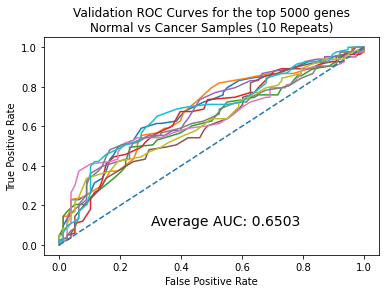

In [ ]:
graphROC(testroc[5000], "Validation ROC Curves for the top 5000 genes\nNormal vs Cancer Samples (10 Repeats)" ,testscore[5000])

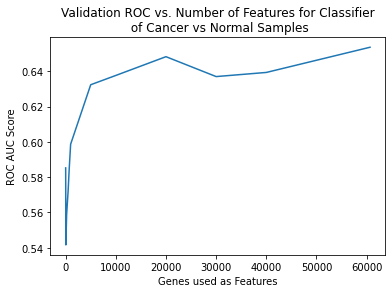

In [ ]:
plotfromScores(testscore2, "Validation ROC vs. Number of Features for Classifier\n of Cancer vs Normal Samples")

In [ ]:
# trying the same features, but using a logistic regression model instead of random forest
logist = LogisticRegression(class_weight='balanced')
logpr, logsc, logroc = testFeatures(normfeats, normnames, comblabel, logist, validtpmT, valY, 5)

In [ ]:
logsc

{10: {'Accuracy': 0.5403726708074534,
  'Balanced Accuracy': 0.5287303058387396,
  'ROC': 0.6234167438986716},
 50: {'Accuracy': 0.5714285714285714,
  'Balanced Accuracy': 0.5646431881371641,
  'ROC': 0.6186283595922151},
 100: {'Accuracy': 0.577639751552795,
  'Balanced Accuracy': 0.5664195242508495,
  'ROC': 0.6428792091442693},
 200: {'Accuracy': 0.577639751552795,
  'Balanced Accuracy': 0.5652610441767069,
  'ROC': 0.6505251776336113},
 500: {'Accuracy': 0.577639751552795,
  'Balanced Accuracy': 0.5652610441767069,
  'ROC': 0.6597930182267532},
 700: {'Accuracy': 0.5652173913043478,
  'Balanced Accuracy': 0.552440531356194,
  'ROC': 0.6728452270620946},
 1000: {'Accuracy': 0.5590062111801242,
  'Balanced Accuracy': 0.5506641952425084,
  'ROC': 0.6791782514674082},
 5000: {'Accuracy': 0.546583850931677,
  'Balanced Accuracy': 0.5386160024714242,
  'ROC': 0.6604881062712389},
 10000: {'Accuracy': 0.5527950310559007,
  'Balanced Accuracy': 0.5438677788075379,
  'ROC': 0.67933271547729

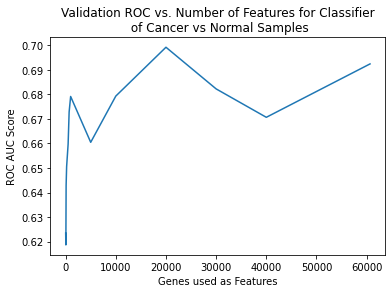

In [ ]:
plotfromScores(logsc, "Validation ROC vs. Number of Features for Classifier\n of Cancer vs Normal Samples")